# Hyperparameter Optimization for NN

Before starting anything, I want to import all libraries that I know I'll need to use; (but, here I added as went along with my project depending on my needs);

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical, normalize
from keras.layers import MaxPool2D, Input, BatchNormalization
from keras.layers import concatenate
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Load the data, split in train test and take a look at it, and the shapes of the splitted dataset:

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

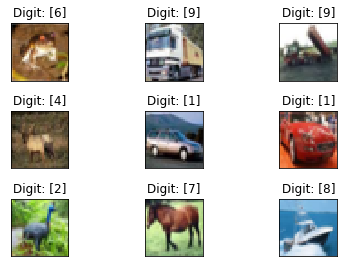

In [0]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(Y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
X_train.shape, Y_train.shape

((50000, 32, 32, 3), (50000, 1))

### Normalize the X_train and X_test, and categorize Y_train and Y_test:
- Data normalization or scaling, will help the model train better.

In [0]:
X_train_norm = tf.keras.utils.normalize(X_train)
X_test_norm = tf.keras.utils.normalize(X_test)

In [0]:
Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)

## Process:

I chose 2 NN that I have previously determined to be the best options, in a previous notebook. I will use hyperparms to choose between the two as well.
- I'll make a list for each of the hyperparameters I want to search.
- I'll do a random search of the said hyperparams; I'll apply it to both models;
- I'll show what I think would be the best model, and why I choose it;

**The hyperparameters I will try to search:**

optimization algorithm

learning rate

network weight initialization

activation function in the hidden layer

dropout rate

the number of neurons in the hidden layer

batch size

#### Python lists for the optimizers:

In [0]:
# set a random seed:

np.random.seed(5)

optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Adadelta', 'Adagrad']
learn_rate = [0.0001, 0.001, 0.01, 0.1, 1]
init_mode = ['uniform','normal', 'zero', 'he_normal', 'he_uniform']
activation = ['relu', 'tanh', 'sigmoid', 'linear']
dropout_rate = [0.2, 0.3, 0.4, 0.5]
filters = [16, 32, 64, 128]
batch_size = [64, 128, 256]



### Define first model: 
- a simple sequential  conv model for the hyperparameters search;

In [0]:
def network(optimizer, learn_rate, init_mode, 
            activation, dropout_rate, 
            filters):
      """
       The parameters I want to search are listed as variables;
       Below are three Conv layers followed each by batch normalization
       dropout layers;

       pooling layers were added two times;
   
       Then I added a dense layer with a preset number or filters: 64
       and activation function relu;
   
       the output dense layer with 10 filters and softmax activation
      """
    model = Sequential()
  
    model.add(Conv2D(filters, (3,3), activation = activation, 
                   input_shape = (32,32,3), kernel_initializer=init_mode))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
  
    model.add(Conv2D(filters, (3,3), activation = activation))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPool2D(2,2))
 
    model.add(Conv2D(filters, (5,5), activation = activation))
    model.add(BatchNormalization())
    model.add(Dropout(rate = dropout_rate))
    model.add(MaxPool2D(2,2))
  
    model.add(Flatten())
  
    model.add(Dense(64, activation = activation))
    model.add(Dense(10, activation = 'softmax'))
  
  
    model.compile(optimizer = optimizer, 
                loss = 'categorical_crossentropy', metrics = ['accuracy'] )
  
      """
      The print hyperparameters found in the search
      """
    print('Optimizer: ' + optimizer+' ', 
        'Learning rate: ' + str(learn_rate) + ' ',
       'Initiation mode: ' + init_mode +' ',
        'Activation: ' + activation +' ',
       'Dropout rate: ' + str(dropout_rate)+' ',
       'Number of filters: '+ str(filters))
       
    return model

### First, I used the sk_learn  function RandomizedSearchCV to search for the best hyperparameters first, below:

In [0]:
model = KerasClassifier(build_fn = network, verbose = 0)

param_search = dict(batch_size=batch_size, optimizer=optimizer, 
                    learn_rate=learn_rate, init_mode=init_mode, 
                    activation=activation, dropout_rate=dropout_rate,
                   filters = filters)

search = RandomizedSearchCV(estimator = model, 
                            param_distributions = param_search, n_jobs = -1)

result = search.fit(X_train_norm, Y_train_cat)

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
W0626 15:35:03.804008 140525397747584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 15:35:03.829876 140525397747584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder in

Optimizer: Adamax  Learning rate: 1  Initiation mode: he_uniform  Activation: linear  Dropout rate: 0.2  Number of filters: 32
Best: 0.304260 using {'optimizer': 'Adamax', 'learn_rate': 1, 'init_mode': 'he_uniform', 'filters': 32, 'dropout_rate': 0.2, 'batch_size': 256, 'activation': 'linear'}
0.096980 (0.001613) with: {'optimizer': 'Adagrad', 'learn_rate': 0.0001, 'init_mode': 'zero', 'filters': 128, 'dropout_rate': 0.2, 'batch_size': 128, 'activation': 'relu'}
0.190600 (0.039779) with: {'optimizer': 'Adam', 'learn_rate': 0.001, 'init_mode': 'normal', 'filters': 16, 'dropout_rate': 0.5, 'batch_size': 128, 'activation': 'sigmoid'}
0.209580 (0.043065) with: {'optimizer': 'Adamax', 'learn_rate': 0.0001, 'init_mode': 'zero', 'filters': 16, 'dropout_rate': 0.4, 'batch_size': 256, 'activation': 'sigmoid'}
0.148560 (0.059552) with: {'optimizer': 'Adamax', 'learn_rate': 0.1, 'init_mode': 'normal', 'filters': 128, 'dropout_rate': 0.5, 'batch_size': 128, 'activation': 'linear'}
0.217420 (0.0236

### Results:

According to the output above, the RandomizedSearchCV got me these choices to be the best:

- 'optimizer': 'Adamax'
- 'learn_rate': 1
- 'init_mode': 'he_uniform'
- 'filters': 32
- 'dropout_rate': 0.2
- 'batch_size': 256
- 'activation': 'linear'

### My own random search:

- I wasn't satisfied with this result, because I had already tried those params on another occasion, and they were not my favorite. So, I decided to do my own random search with a custom loop, and pass the first model through it:

In [0]:
import random

# Collect all accuracies for all the epochs during training:
          
histories = []
  

for i in range(1,11):
    print(str(i) + ' Training with:')
          
    # Collect accuracies for the epochs during training each model:
    accuracies = []
  
    # Assign with a random choice for each variable in the network function:
    
    model = network(random.choice(optimizer), random.choice(learn_rate),
                  random.choice(init_mode), random.choice(activation),
                  random.choice(dropout_rate), random.choice(filters))
  
     #I used callbacks for the optimisation of the number of epochs,
     # Monitoring validation accuracy:
      
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                              patience=3,
                              verbose=0, mode='auto')
          
   
       
        #Assign random value the batch size and print it:   
    batch = random.choice(batch_size)
    print('Batch size: '+str(batch))
  
   
         #fit the model
  
    h = model.fit(X_train_norm, Y_train_cat, 
              batch_size = batch, 
              epochs = 30,
             validation_split = 0.2, callbacks = [callback],
                verbose = 0)
 
  
    #Collect the accuracies as the model trains for each i:
    
    accuracies.append(h.history['acc'])
  
    i+=1
  
    print(accuracies)
  
    histories.append (accuracies)
  
  

1 Training with:
Optimizer: Adadelta  Learning rate: 0.001  Initiation mode: uniform  Activation: tanh  Dropout rate: 0.3  Number of filters: 64
Batch size: 256
[[0.332175, 0.434425, 0.479475, 0.511075]]
2 Training with:
Optimizer: Adadelta  Learning rate: 0.1  Initiation mode: normal  Activation: relu  Dropout rate: 0.2  Number of filters: 64
Batch size: 128
[[0.36305, 0.486425, 0.5539, 0.604125, 0.63245, 0.66685, 0.69545, 0.713025, 0.732075, 0.75025, 0.7665]]
3 Training with:
Optimizer: Adagrad  Learning rate: 1  Initiation mode: he_uniform  Activation: sigmoid  Dropout rate: 0.2  Number of filters: 64
Batch size: 64
[[0.426575, 0.54045, 0.58075, 0.60705, 0.623325, 0.640275, 0.65265, 0.66525, 0.671575, 0.68165, 0.688325, 0.69525, 0.7, 0.70595, 0.710475, 0.7181, 0.72355, 0.72735, 0.72925, 0.732525, 0.735475, 0.740875]]
4 Training with:
Optimizer: RMSprop  Learning rate: 1  Initiation mode: zero  Activation: sigmoid  Dropout rate: 0.2  Number of filters: 64
Batch size: 256
[[0.35765, 0

### Results:

- I like these results better as they are close to what I found to be more useful. NOw I'll plot them for visualization.

- First, I transformed all results from the list of lists 'histories' into independent arrays for each model sample to plot them:

In [0]:
x1 = np.asarray(histories[0]).flatten().transpose()
x2 = np.asarray(histories[1]).flatten().transpose()
x3 = np.asarray(histories[2]).flatten().transpose()
x4 = np.asarray(histories[3]).flatten().transpose()
x5 = np.asarray(histories[4]).flatten().transpose()
x6 = np.asarray(histories[5]).flatten().transpose()
x7 = np.asarray(histories[6]).flatten().transpose()
x8 = np.asarray(histories[7]).flatten().transpose()
x9 = np.asarray(histories[8]).flatten().transpose()
x10 = np.asarray(histories[9]).flatten().transpose()



Plotting the learning curves of all the random models:

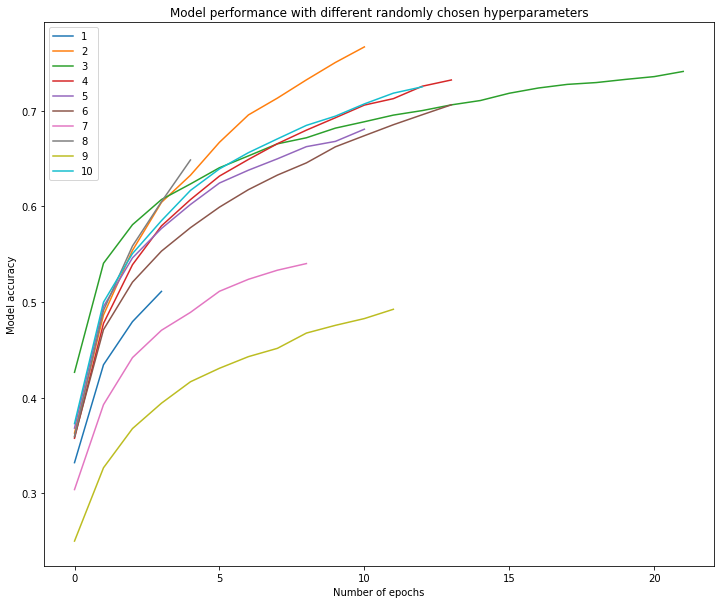

In [0]:
fig= plt.figure(figsize=(12,10))


plt.plot(x1, label = '1')
plt.plot(x2, label = '2')
plt.plot(x3, label = '3')
plt.plot(x4, label = '4')
plt.plot(x5, label = '5')
plt.plot(x6, label = '6')
plt.plot(x7, label = '7')
plt.plot(x8, label = '8')
plt.plot(x9, label = '9')
plt.plot(x10, label = '10')
plt.title('Model performance with different randomly chosen hyperparameters')
plt.xlabel('Number of epochs')
plt.ylabel('Model accuracy')
plt.legend()

### Analysis:

As can be seen from the graph above, the model with the best accuracy was the second one, orange line, with highest acc value at 0.7665.

From the output of the loop we can see the hyperparameters found in this case being the following:

Optimizer: Adadelta  
Learning rate: 0.1  
Initiation mode: normal  
Activation: relu  
Dropout rate: 0.2  
Number of filters: 64
Batch size: 128



## Second model:

While working on another of my notebooks, I found that functional models worked a little better sometimes, so I want to try to see if searching for the best hyperparams will give me something better that the simple model above.


#### First, I redefined a new model using the functional API:

In [0]:
def func_network(optimizer, learn_rate, init_mode, 
            activation, dropout_rate, 
            filters):
  
  inputs = Input(shape=(32,32,3))
  
  """The model has two conv layers with batch norm dropout and maxpooling
     they are flattened and concatenated together
     followed by a dense layer with a predertmined number of filters
  """

    x = Conv2D(filters,(3,3), activation=activation, 
             kernel_initializer = init_mode)(inputs)
    x1 = BatchNormalization()(x)
    x2 = Dropout(rate=dropout_rate)(x1)
    x3 = MaxPool2D(2,2)(x2)
    x4 = Flatten()(x3)


    y = Conv2D(filters,(5,5), activation=activation,
            kernel_initializer = init_mode)(inputs)
    y1 = BatchNormalization()(y)
    y2 = Dropout(rate=dropout_rate)(y)
    y3 = MaxPool2D(2,2)(y2)
    y4 = Flatten()(y3)


    a = concatenate([x4, y4])


    dense = Dense(64, activation = 'relu')(a)

    outputs = Dense(10, activation = 'softmax')(dense)

    func_model = Model(inputs, outputs)
  
    func_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
      """
      print hyperparameters found in the search
      """
    print('Optimizer: ' + optimizer+' ', 
        'Learning rate: ' + str(learn_rate) + ' ',
       'Initiation mode: ' + init_mode +' ',
        'Activation: ' + activation +' ',
       'Dropout rate: ' + str(dropout_rate)+' ',
       'Number of filters: '+ str(filters))
       
    return func_model

#### Pass it though my random search loop (very similar to the first one):

In [0]:
# Collect all accuracies for all the epochs during training:
          
histories2 = []
  

for i in range(1,11):
  
  print(str(i) + ' Training with:')
          
    # Collect accuracies the epochs during training:
    accuracies2 = []
    # Assign with a random choice for each variable in the network function 
    
    model = func_network(random.choice(optimizer), random.choice(learn_rate),
                  random.choice(init_mode), random.choice(activation),
                  random.choice(dropout_rate), random.choice(filters))
  
     #I used callbacks for the optimisation of the number of epochs
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                              patience=3,
                              verbose=0, mode='auto')
          
   
       
        #Assign random value the batch size and print it:   
    batch = random.choice(batch_size)
    print('Batch size: '+str(batch))
  
   
         #fit the model
  
    h = model.fit(X_train_norm, Y_train_cat, 
              batch_size = batch, 
              epochs = 30,
             validation_split = 0.2, callbacks = [callback],
                verbose = 0)
 
  
    #Collect the accuracies as the model trains for each i:
    
    accuracies2.append(h.history['acc'])
  
    i+=1
  
    print(accuracies2)
    
    histories2.append (accuracies2)

1 Training with:
Optimizer: Adagrad  Learning rate: 0.1  Initiation mode: he_uniform  Activation: tanh  Dropout rate: 0.4  Number of filters: 16
Batch size: 128
[[0.8989949789047241, 0.9064624739646912, 0.9103249746322631, 0.9130949728012085, 0.9152349807739257, 0.9165274759292602]]
2 Training with:
Optimizer: Adam  Learning rate: 0.1  Initiation mode: zero  Activation: linear  Dropout rate: 0.3  Number of filters: 32
Batch size: 64
[[0.9036949759483337, 0.9127749782562256, 0.916892481136322, 0.9201924817085266, 0.9227749846458435, 0.9244649837493897, 0.9264674859046936]]
3 Training with:
Optimizer: RMSprop  Learning rate: 0.001  Initiation mode: uniform  Activation: tanh  Dropout rate: 0.3  Number of filters: 16
Batch size: 128
[[0.9041799798965454, 0.9134099800109863, 0.9182099849700928, 0.9217274824142456, 0.924427487373352, 0.9269649864196777, 0.9293324876785278, 0.9312974907875061, 0.9338224914550781, 0.935759992980957]]
4 Training with:
Optimizer: Adadelta  Learning rate: 0.1  In

#### Plot the results:

Transform the data for plotting:

In [0]:
y1 = np.asarray(histories2[0]).flatten().transpose()
y2 = np.asarray(histories2[1]).flatten().transpose()
y3 = np.asarray(histories2[2]).flatten().transpose()
y4 = np.asarray(histories2[3]).flatten().transpose()
y5 = np.asarray(histories2[4]).flatten().transpose()
y6 = np.asarray(histories2[5]).flatten().transpose()
y7 = np.asarray(histories2[6]).flatten().transpose()
y8 = np.asarray(histories2[7]).flatten().transpose()
y9 = np.asarray(histories2[8]).flatten().transpose()
y10 = np.asarray(histories2[9]).flatten().transpose()

Plot the model for the functional model performance:

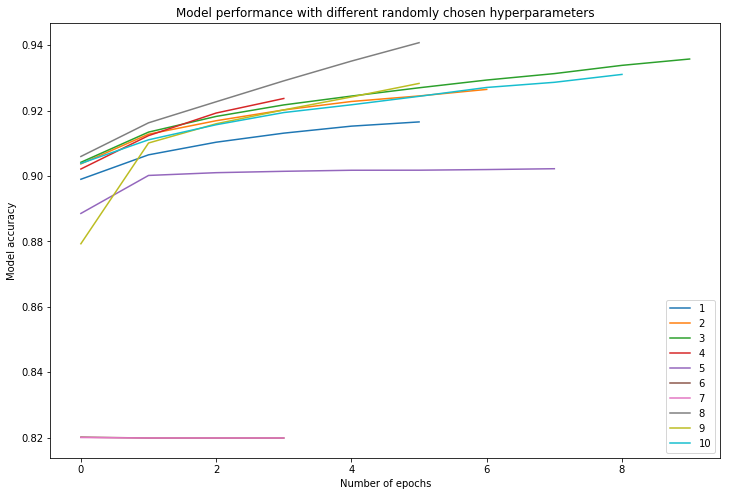

In [0]:
fig= plt.figure(figsize=(12,8))


plt.plot(y1, label = '1')
plt.plot(y2, label = '2')
plt.plot(y3, label = '3')
plt.plot(y4, label = '4')
plt.plot(y5, label = '5')
plt.plot(y6, label = '6')
plt.plot(y7, label = '7')
plt.plot(y8, label = '8')
plt.plot(y9, label = '9')
plt.plot(y10, label = '10')
plt.title('Model performance with different randomly chosen hyperparameters')
plt.xlabel('Number of epochs')
plt.ylabel('Model accuracy')
plt.legend()

### Results:

This model still performed better than the sequential one and the best accuracy was found at the 8th model, the grey line, at a value of 0.941 with the following parameters:



>Optimizer: Adadelta  
Learning rate: 0.001  
Initiation mode: he_normal  
Activation: relu  
Dropout rate: 0.2  
Number of filters: 64

> Batch size: 64











### Decision time:

I still did like the functional model more, so I'm going ahead with fitting this one for final evaluation.

Fitting the model with the chosen hyperparams:

In [0]:
inputs = Input(shape=(32,32,3))

x = Conv2D(64,(3,3), activation='relu', kernel_initializer= 'he_normal')(inputs)
x1 = BatchNormalization()(x)
x2 = Dropout(0.2)(x1)
x3 = MaxPool2D(2,2)(x2)
x4 = Flatten()(x3)


y = Conv2D(64,(5,5), activation='relu')(inputs)
y1 = BatchNormalization()(y)
y2 = Dropout(0.2)(y)
y3 = MaxPool2D(2,2)(y2)
y4 = Flatten()(y3)


a = concatenate([x4, y4])


dense = Dense(64, activation = 'relu')(a)

outputs = Dense(10, activation = 'softmax')(dense)

func_model = Model(inputs, outputs)

func_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 30, 30, 64)   1792        input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 30, 30, 64)   256         conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 28, 28, 64)   4864        input_14[0][0]                   
__________________________________________________________________________________________________
dropout_58

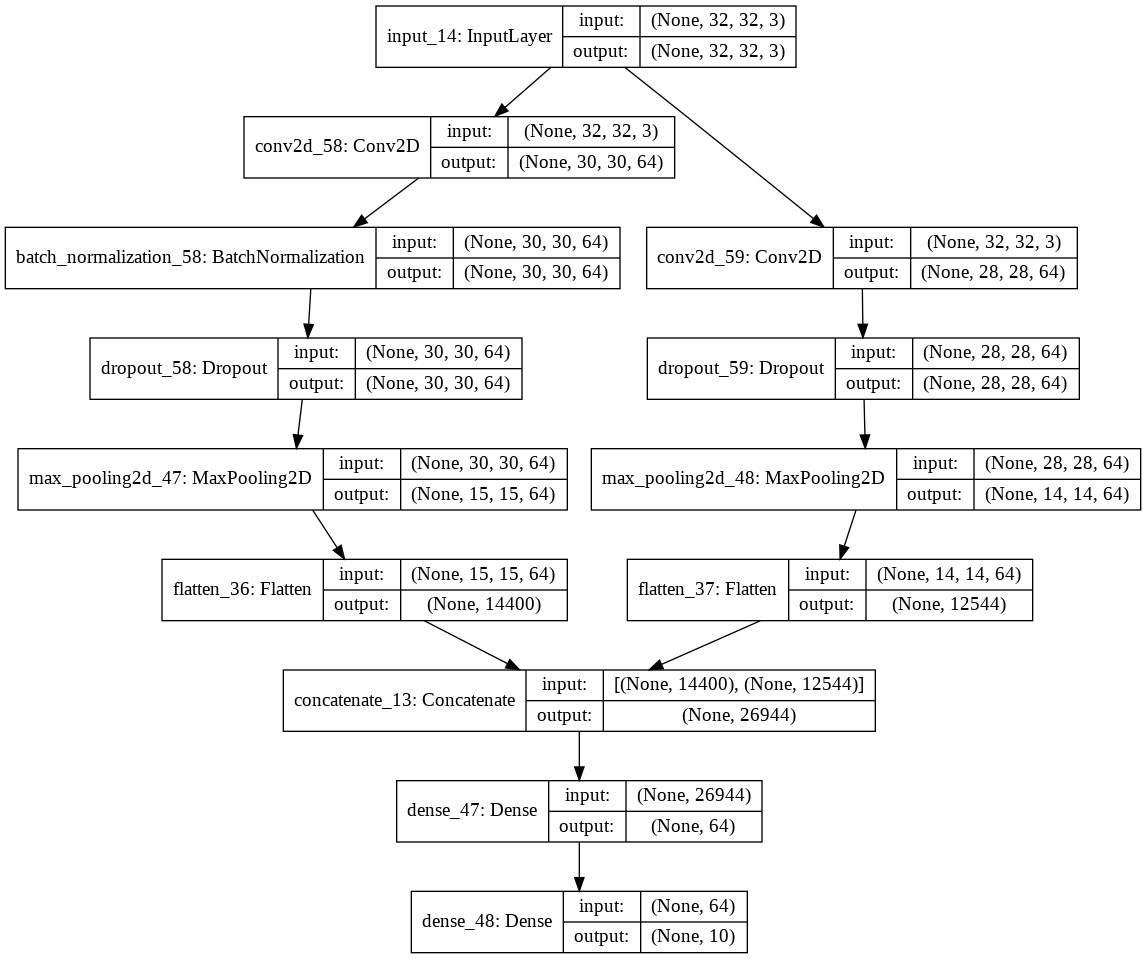

In [0]:
tf.keras.utils.plot_model(
    func_model, 
    to_file='{}.png'.format(func_model), 
    show_shapes=True, 
    show_layer_names=True)

from IPython.display import Image
Image(retina=True, filename='{}.png'.format(func_model))

Compile and train the model:

In [0]:
func_model.compile(optimizer=optimizers.Adadelta(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
m = func_model.fit(X_train_norm, Y_train_cat, epochs=30, 
                   batch_size=64, callbacks = [early_stop], validation_split = 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 15s 384us/step - loss: 0.3247 - acc: 0.8976 - val_loss: 0.3099 - val_acc: 0.8980
Epoch 2/30
40000/40000 [==============================] - 10s 250us/step - loss: 0.3018 - acc: 0.8988 - val_loss: 0.2997 - val_acc: 0.8987
Epoch 3/30
40000/40000 [==============================] - 10s 248us/step - loss: 0.2932 - acc: 0.8994 - val_loss: 0.2940 - val_acc: 0.8991
Epoch 4/30
40000/40000 [==============================] - 10s 248us/step - loss: 0.2875 - acc: 0.8999 - val_loss: 0.2897 - val_acc: 0.8996
Epoch 5/30
40000/40000 [==============================] - 10s 251us/step - loss: 0.2834 - acc: 0.9004 - val_loss: 0.2865 - val_acc: 0.8998
Epoch 6/30
40000/40000 [==============================] - 10s 252us/step - loss: 0.2794 - acc: 0.9010 - val_loss: 0.2840 - val_acc: 0.9001
Epoch 7/30
40000/40000 [==============================] - 10s 252us/step - loss: 0.2765 - acc: 0.9014 - val_loss: 0.

Plot model performance:

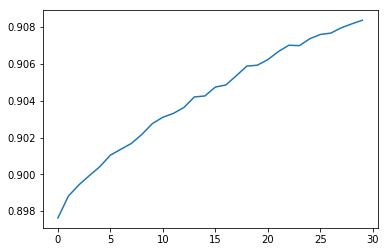

In [0]:
plt.plot(m.history['acc'])

Making predictions:

In [0]:
func_model.evaluate(X_test_norm, Y_test_cat)

10000/10000 [==============================] - 1s 132us/step


[0.25821624217033384, 0.9058399772644044]

### Conclusion:

This functional model's accuracy was lower that what I initially had in my previous cifar10 notebook,  where the hyperparams were chosen as a trial and error method.

However, this model seems to have better validation accuracy and it is more consistent with the predictions than in the previous notebook.

